In [8]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def splitSamples(data, label, train_size):
    unique_classes = np.unique(label)  #获取唯一的类别标签
    precentage = train_size
    
    trainData = []
    trainLabel = []
    testData = []
    testLabel = []

    for i in unique_classes:
        index = np.where(label == i)[0]
        np.random.shuffle(index)
        num_train = int(precentage * len(index))    #使用int得到截断值
        index_train = index[:num_train]
        index_test = index[num_train:]

        trainData.extend(data[index_train, :])
        trainLabel.extend(label[index_train])
        testData.extend(data[index_test, :])
        testLabel.extend(label[index_test])
    
    trainData = np.array(trainData)
    trainLabel = np.array(trainLabel).reshape(-1, 1)
    testData = np.array(testData)
    testLabel = np.array(testLabel).reshape(-1, 1)

    return trainData, trainLabel, testData, testLabel

In [10]:
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time 

#导入之前得到的图像数据
file = h5py.File('DB2_S8_image_200_0.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]
file.close()

#将数据和标签分割成测试集和训练集
trainData, trainLabel, testData, testLabel = splitSamples(imageData, imageLabel, train_size=0.8)
#对数据升维
trainData = np.expand_dims(trainData,axis=3)
testData = np.expand_dims(testData,axis=3)

#将训练集和测试集的标签转为独热编码one-hot
trainLabel = tf.keras.utils.to_categorical(trainLabel)
testLabel = tf.keras.utils.to_categorical(testLabel)

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

# 定义输入形状
input_shape2 = (200, 12, 1)

# 输入层
input_layer2 = Input(shape=input_shape2)

# 第一个卷积分支
branch1 = Conv2D(32, kernel_size=(32, 3), padding='same', activation='relu')(input_layer2)
branch1 = MaxPooling2D(pool_size=(20, 1))(branch1)
branch1 = Conv2D(64, kernel_size=(6, 1), padding='same', activation='relu')(branch1)
branch1 = MaxPooling2D(pool_size=(2, 1))(branch1)

# 第二个卷积分支
branch2 = Conv2D(32, kernel_size=(20, 3), padding='same', activation='relu')(input_layer2)
branch2 = MaxPooling2D(pool_size=(20, 1))(branch2)
branch2 = Conv2D(64, kernel_size=(8, 1), padding='same', activation='relu')(branch2)
branch2 = MaxPooling2D(pool_size=(2, 1))(branch2)

branch3 = Conv2D(32, kernel_size=(16, 3), padding='same', activation='relu')(input_layer2)
branch3 = MaxPooling2D(pool_size=(20, 1))(branch3)
branch3 = Conv2D(64, kernel_size=(12, 1), padding='same', activation='relu')(branch3)
branch3 = MaxPooling2D(pool_size=(2, 1))(branch3)

branch4 = Conv2D(32, kernel_size=(8, 3), padding='same', activation='relu')(input_layer2)
branch4 = MaxPooling2D(pool_size=(20, 1))(branch4)
branch4 = Conv2D(64, kernel_size=(16, 1), padding='same', activation='relu')(branch4)
branch4 = MaxPooling2D(pool_size=(2, 1))(branch4)


# 合并两个分支
merged_branches2 = concatenate([branch1, branch2, branch3, branch4])

# 进一步处理合并后的特征
merged_branches2 = Conv2D(128, kernel_size=(3, 3), activation='relu')(merged_branches2)
merged_branches2 = MaxPooling2D(pool_size=(1, 1))(merged_branches2)

# 全连接层
merged_branches2 = Flatten()(merged_branches2)
output_layer2 = Dropout(0.5)(merged_branches2)
output_layer2 = Dense(128,activation = 'relu')(output_layer2)
output_layer2 = Dropout(0.4)(output_layer2)
output_layer2 = Dense(49, activation='softmax')(output_layer2)

# 定义模型
model2 = Model(inputs=input_layer2, outputs=output_layer2)

# 编译模型
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型结构
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 12,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 200, 12,   │      3,104 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 200, 12,   │      1,952 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 200, 12,   │      1,568 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 200, 12,   │        800 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 10, 12,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 10, 12,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 10, 12,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 10, 12,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 10, 12,    │     12,352 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 10, 12,    │     16,448 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 10, 12,    │     24,640 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 10, 12,    │     32,832 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 5, 12, 64) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 5, 12, 64) │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 5, 12, 64) │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 5, 12, 64) │          0 │ conv2d_16[0][0] 

 Total params: 886,705 (3.38 MB)

 Trainable params: 886,705 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import time
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()

# 训练模型
'''model参数：
verbose————日志显示模式，0 表示不在标准输出流输出日志信息，
                     1 表示输出进度条记录，
                     2 表示每个 epoch 输出一行记录。'''
history2 = model2.fit(trainData, trainLabel, epochs=300, batch_size=280)

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.0415 - loss: 3.9162
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.0987 - loss: 3.5555
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.1706 - loss: 3.1780
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.2523 - loss: 2.7364
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.3322 - loss: 2.3412
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4123 - loss: 2.0049
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4385 - loss: 1.8907
Epoch 8/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.4969 - loss: 1.6840
Epoch 9/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5089 - loss: 1.5747
Epoch 10/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5451 - loss: 1.4489
Epoch 11/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5511 - loss: 1.4105
Epoch 12/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 4

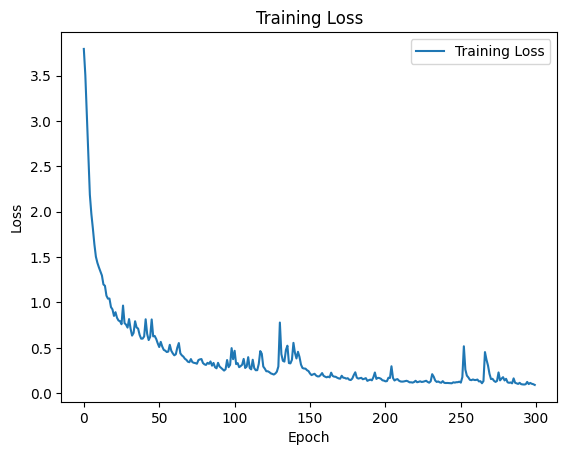

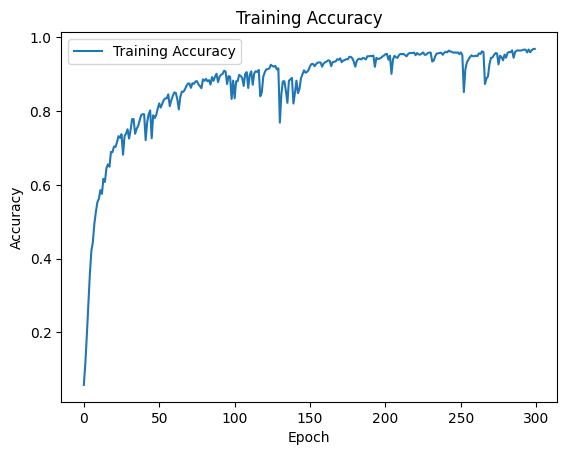

324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0036
Train accuracy: 0.9992279410362244
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9267 - loss: 0.3385
Test Loss = 0.31367066502571106
Test Accuracy = 0.919404149055481
训练模型花费的时间: 1505.02 秒


In [13]:
# 绘制训练损失和验证损失曲线
plt.plot(history2.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率和验证准确率曲线
plt.plot(history2.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 评估模型
train_loss2, train_acc2 = model2.evaluate(trainData, trainLabel)
print('Train accuracy:', train_acc2)

# 使用模型进行预测
predictions2 = model2.evaluate(testData, testLabel)
print("Test Loss = " + str(predictions2[0]))
print("Test Accuracy = " + str(predictions2[1]))
print('训练模型花费的时间: %.2f 秒' % (time.time() - start_time))

In [14]:
import json

# 训练模型
# 将 history 转换为字典
history_dict = history2.history

# 保存为 JSON 文件
with open('history3-s8.json', 'w') as json_file:
    json.dump(history_dict, json_file)